In [ ]:
# 

In [3]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

house_prices <- source('main.R', local = TRUE)$value

combined_dataset <- house_prices$helpers$load_data()
combined_dataset %>% dim %>% print
combined_dataset %>% filter(dataSource == "train") %>% dim %>% print
combined_dataset %>% filter(dataSource == "test") %>% dim %>% print

[1] 2919   82
[1] 1460   82
[1] 1459   82


In [14]:
character_colnames <- house_prices$helpers$get_character_colnames(combined_dataset)
numeric_colnames <- house_prices$helpers$get_numeric_colnames(combined_dataset)

character_colnames %>% length
character_colnames %>% print

numeric_colnames %>% length
numeric_colnames %>% print

[1] 45

 [1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"      "CentralAir"   
 [9] "Condition1"    "Condition2"    "Electrical"    "ExterCond"    
[13] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[17] "FireplaceQu"   "Foundation"    "Functional"    "GarageCond"   
[21] "GarageFinish"  "GarageQual"    "GarageType"    "Heating"      
[25] "HeatingQC"     "HouseStyle"    "KitchenQual"   "LandContour"  
[29] "LandSlope"     "LotConfig"     "LotShape"      "MasVnrType"   
[33] "MiscFeature"   "MoSold"        "MSSubClass"    "MSZoning"     
[37] "Neighborhood"  "PavedDrive"    "PoolQC"        "RoofMatl"     
[41] "RoofStyle"     "SaleCondition" "SaleType"      "Street"       
[45] "Utilities"    


[1] 35

 [1] "BedroomAbvGr"  "BsmtFinSF1"    "BsmtFinSF2"    "BsmtFullBath" 
 [5] "BsmtHalfBath"  "BsmtUnfSF"     "EnclosedPorch" "Fireplaces"   
 [9] "FullBath"      "GarageArea"    "GarageCars"    "GarageYrBlt"  
[13] "GrLivArea"     "HalfBath"      "KitchenAbvGr"  "LotArea"      
[17] "LotFrontage"   "LowQualFinSF"  "MasVnrArea"    "MiscVal"      
[21] "OpenPorchSF"   "OverallCond"   "OverallQual"   "PoolArea"     
[25] "SalePrice"     "ScreenPorch"   "TotalBsmtSF"   "TotRmsAbvGrd" 
[29] "WoodDeckSF"    "X1stFlrSF"     "X2ndFlrSF"     "X3SsnPorch"   
[33] "YearBuilt"     "YearRemodAdd"  "YrSold"       


In [19]:
categ_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_character_colnames(combined_dataset), SalePrice)

categ_data %>% glimpse

Observations: 2,919
Variables: 46
$ Alley         <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ BldgType      <chr> "1Fam", "1Fam", "1Fam", "1Fam", "1Fam", "1Fam", "1Fam...
$ BsmtCond      <chr> "TA", "TA", "TA", "Gd", "TA", "TA", "TA", "TA", "TA",...
$ BsmtExposure  <chr> "No", "Gd", "Mn", "No", "Av", "No", "Av", "Mn", "No",...
$ BsmtFinType1  <chr> "GLQ", "ALQ", "GLQ", "ALQ", "GLQ", "GLQ", "GLQ", "ALQ...
$ BsmtFinType2  <chr> "Unf", "Unf", "Unf", "Unf", "Unf", "Unf", "Unf", "BLQ...
$ BsmtQual      <chr> "Gd", "Gd", "Gd", "TA", "Gd", "Gd", "Ex", "Gd", "TA",...
$ CentralAir    <chr> "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y"...
$ Condition1    <chr> "Norm", "Feedr", "Norm", "Norm", "Norm", "Norm", "Nor...
$ Condition2    <chr> "Norm", "Norm", "Norm", "Norm", "Norm", "Norm", "Norm...
$ Electrical    <chr> "SBrkr", "SBrkr", "SBrkr", "SBrkr", "SBrkr", "SBrkr",...
$ ExterCond     <chr> "TA", "TA", "TA", "TA", "TA", "TA", "TA", "TA", "TA",...
$ Exterior1st   <c

In [21]:
numeric_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_numeric_colnames(combined_dataset))

numeric_data %>% glimpse

Observations: 2,919
Variables: 35
$ BedroomAbvGr  <int> 3, 3, 3, 3, 4, 1, 3, 3, 2, 2, 3, 4, 2, 3, 2, 2, 2, 2,...
$ BsmtFinSF1    <int> 706, 978, 486, 216, 655, 732, 1369, 859, 0, 851, 906,...
$ BsmtFinSF2    <int> 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ BsmtFullBath  <int> 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,...
$ BsmtHalfBath  <int> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ BsmtUnfSF     <int> 150, 284, 434, 540, 490, 64, 317, 216, 952, 140, 134,...
$ EnclosedPorch <int> 0, 0, 0, 272, 0, 0, 0, 228, 205, 0, 0, 0, 0, 0, 176, ...
$ Fireplaces    <int> 0, 1, 1, 1, 1, 0, 1, 2, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0,...
$ FullBath      <int> 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 2,...
$ GarageArea    <int> 548, 460, 608, 642, 836, 480, 636, 484, 468, 205, 384...
$ GarageCars    <int> 2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 1, 3, 1, 3, 1, 2, 2, 2,...
$ GarageYrBlt   <int> 2003, 1976, 2001, 1998, 2000, 1993, 2004, 1973, 1931,...
$ GrLivArea     <i

# Entropy of attribute distributions

In [29]:
entropy <- house_prices$attributes_selection$entropy

categ_vars_by_entropy <- entropy$arrange_vars(categ_data %>% select(-SalePrice))
numeric_vars_by_entropy <- entropy$arrange_vars(numeric_data %>% select(-SalePrice))

bind_cols(categ_vars_by_entropy %>% head, categ_vars_by_entropy %>% tail)
bind_cols(numeric_vars_by_entropy %>% head, numeric_vars_by_entropy %>% tail)

var,entropy,var1,entropy1
Utilities,0.01262749,BsmtFinType1,2.454724
PoolQC,0.03820308,Exterior1st,2.723429
Street,0.03850369,Exterior2nd,2.800720
Condition2,0.10643374,MSSubClass,2.920021
RoofMatl,0.13851938,MoSold,3.393870
Heating,0.13977521,Neighborhood,4.212100


var,entropy,var1,entropy1
PoolArea,0.05767714,GarageArea,7.968793
X3SsnPorch,0.15876902,TotalBsmtSF,9.348757
LowQualFinSF,0.17326513,BsmtUnfSF,9.390885
KitchenAbvGr,0.28095915,X1stFlrSF,9.601608
BsmtHalfBath,0.34480765,GrLivArea,9.882939
MiscVal,0.37490332,LotArea,10.400602


# Normal Paper applied to targer variable

In [30]:
target_normal_paper <-
    combined_dataset %>% 
    select(price=SalePrice) %>% 
    na.omit %>%
    mutate(
        price_log = log(price)
    ) %>%
    gather(var, value) %>%
    group_by(var) %>%
    mutate(
        normed_value = (value - mean(value)) / sd(value)
    )

target_normal_paper %>% arrange(var, value) %>% top_n(3, value)

var,value,normed_value
price,625000.00000,5.589940
price,745000.00000,7.100466
price,755000.00000,7.226343
price_log,13.34551,3.308173
price_log,13.52114,3.747857
price_log,13.53447,3.781237


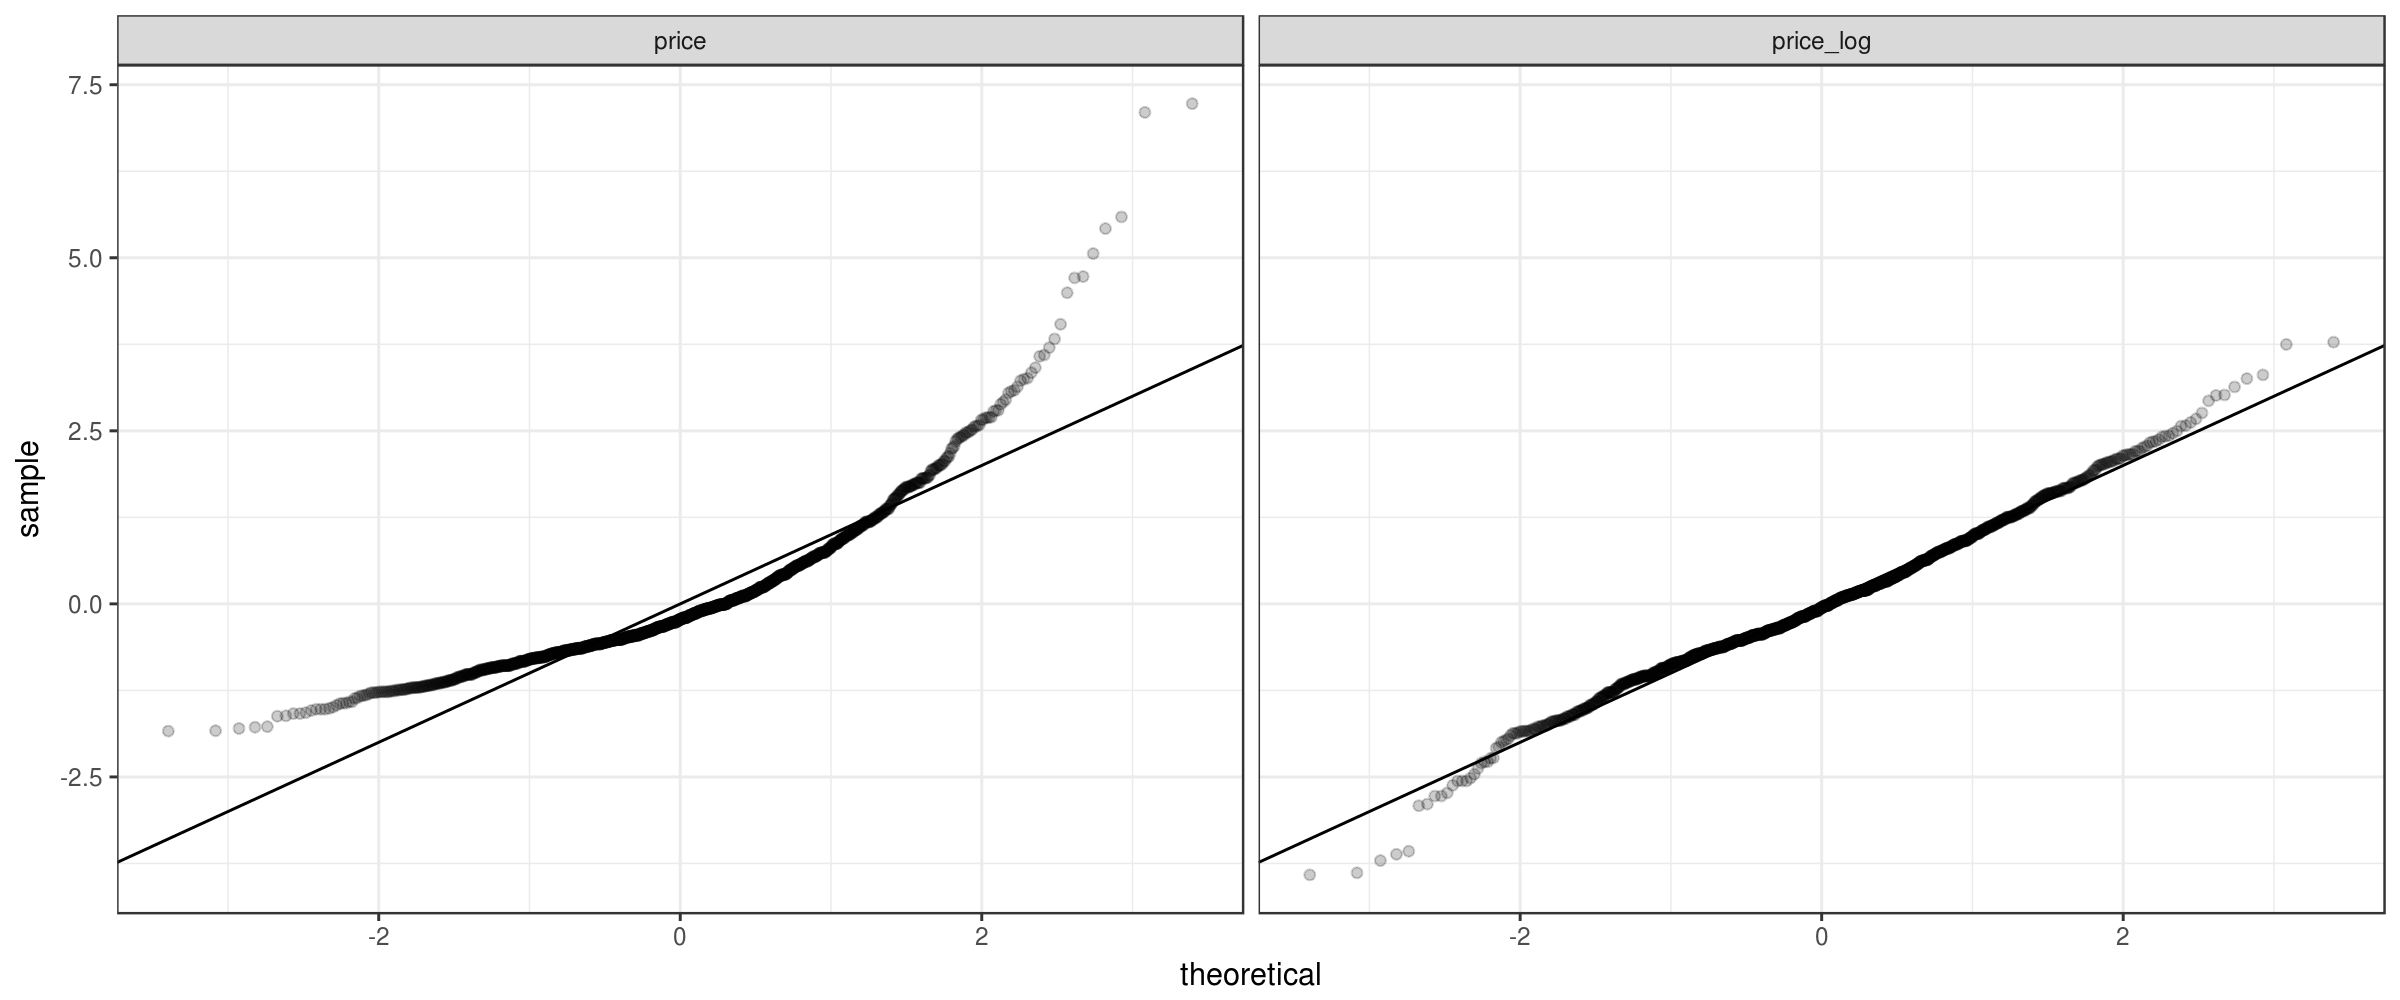

In [31]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res=200)

target_normal_paper %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(~var, ncol=2) +
geom_abline(slope=1) +
theme_bw()

### Deviation from perfect normal distribution. Notice that log(SalePrice) is much more normal

In [31]:
target_normal_paper %>%
group_by(var, normed_value) %>%
arrange(var, normed_value) %>%
summarise(
    k = n()
) %>%
mutate(
    empirical = cumsum(k) / sum(k),
    theoretical = pnorm(normed_value),
    L2_delta = k*(empirical - theoretical)**2
) %>% 
group_by(var) %>%
summarise(
    L2 = sum(L2_delta)
)

var,L2
price,7.4623329
price_log,0.6496542


# Separation between groups

This is custom measure of how levels of categorical variables are separated relative to sale price. The more is separation the more should be variable meaningful for price prediction. If there is no separation between levels than variable is useless.

In [32]:
groups_separation <- house_prices$attributes_selection$groups_separation

precalculated <- 
    groups_separation$precalculated(
        df = categ_data,
        target_var = SalePrice
    )

precalculated %>% head(5)

categ_vars_by_groups_separation <- groups_separation$arrange_vars(categ_data, SalePrice)

var,value,n,mean,std,freq,lead_mean,lead_freq,lead_std
Alley,Grvl,50,122219.1,34780.78,0.03424658,168000.6,0.02808219,38370.38
Alley,Pave,41,168000.6,38370.38,0.02808219,183452.1,0.93767123,80667.15
Alley,NA,1369,183452.1,80667.15,0.93767123,NA,NA,NA
BldgType,2fmCon,31,128432.3,35458.55,0.02123288,133541.1,0.03561644,27833.25
BldgType,Duplex,52,133541.1,27833.25,0.03561644,135911.6,0.02945205,41013.22


In [33]:
bind_cols(categ_vars_by_groups_separation %>% head, categ_vars_by_groups_separation %>% tail)

var,score,var1,score1
Utilities,0.0002047587,BsmtFinType1,0.1211155
LotConfig,0.0005070409,CentralAir,0.2042301
Functional,0.0006479951,GarageFinish,0.2756040
MoSold,0.0007162101,BsmtQual,0.4210981
PoolQC,0.0010659277,KitchenQual,0.4775291
Condition2,0.0012226735,ExterQual,0.4871526


### Visualising separation by two opposite cases

In [34]:
# Helper function that orderes factor levels by SalePrice mean value at that level.
# Otherwise ggplot will order levels lexicographically.

order_factor_by_target <- house_prices$attributes_selection$order_factor_by_target

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
)$ExterQual %>% levels

[1] "Fa" "TA" "Gd" "Ex"

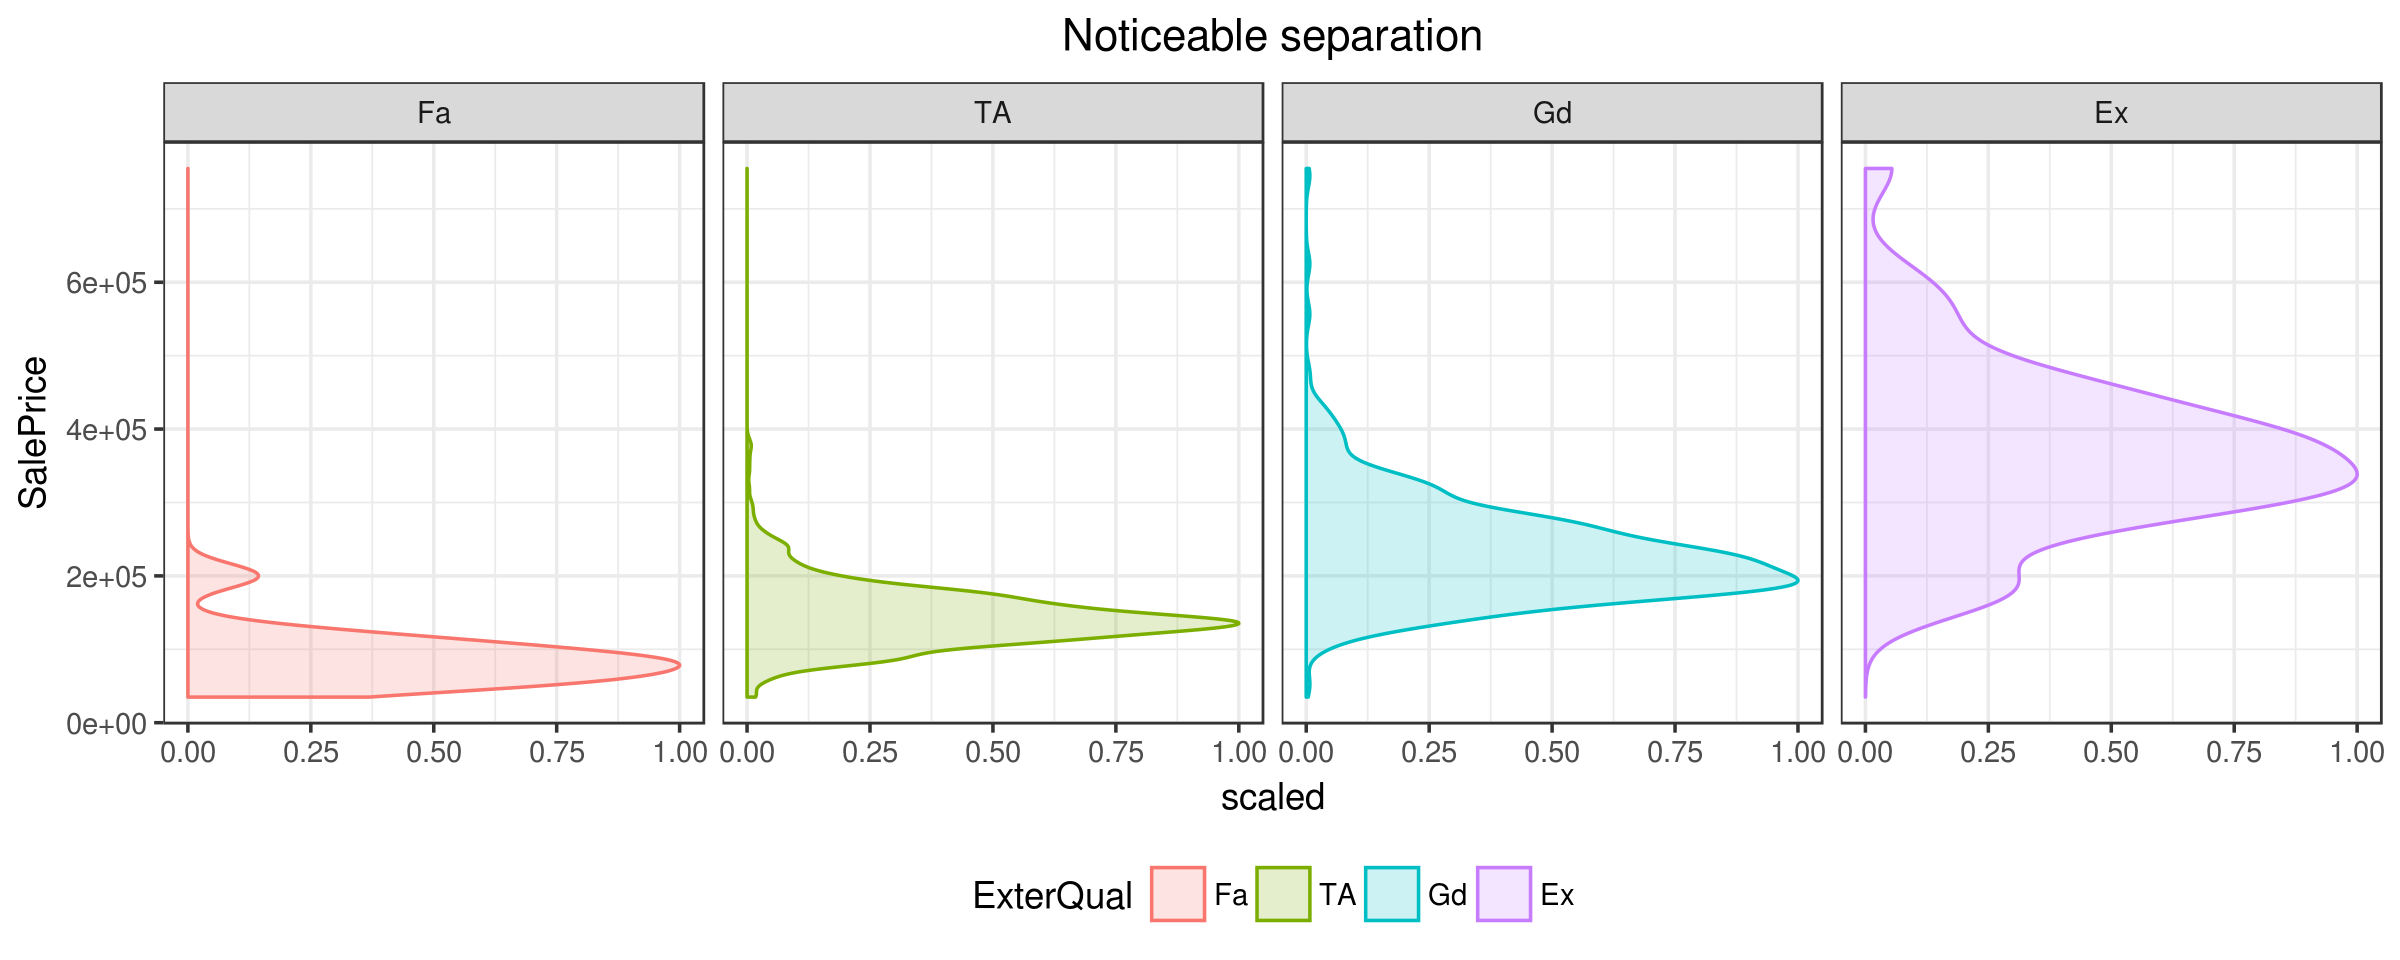

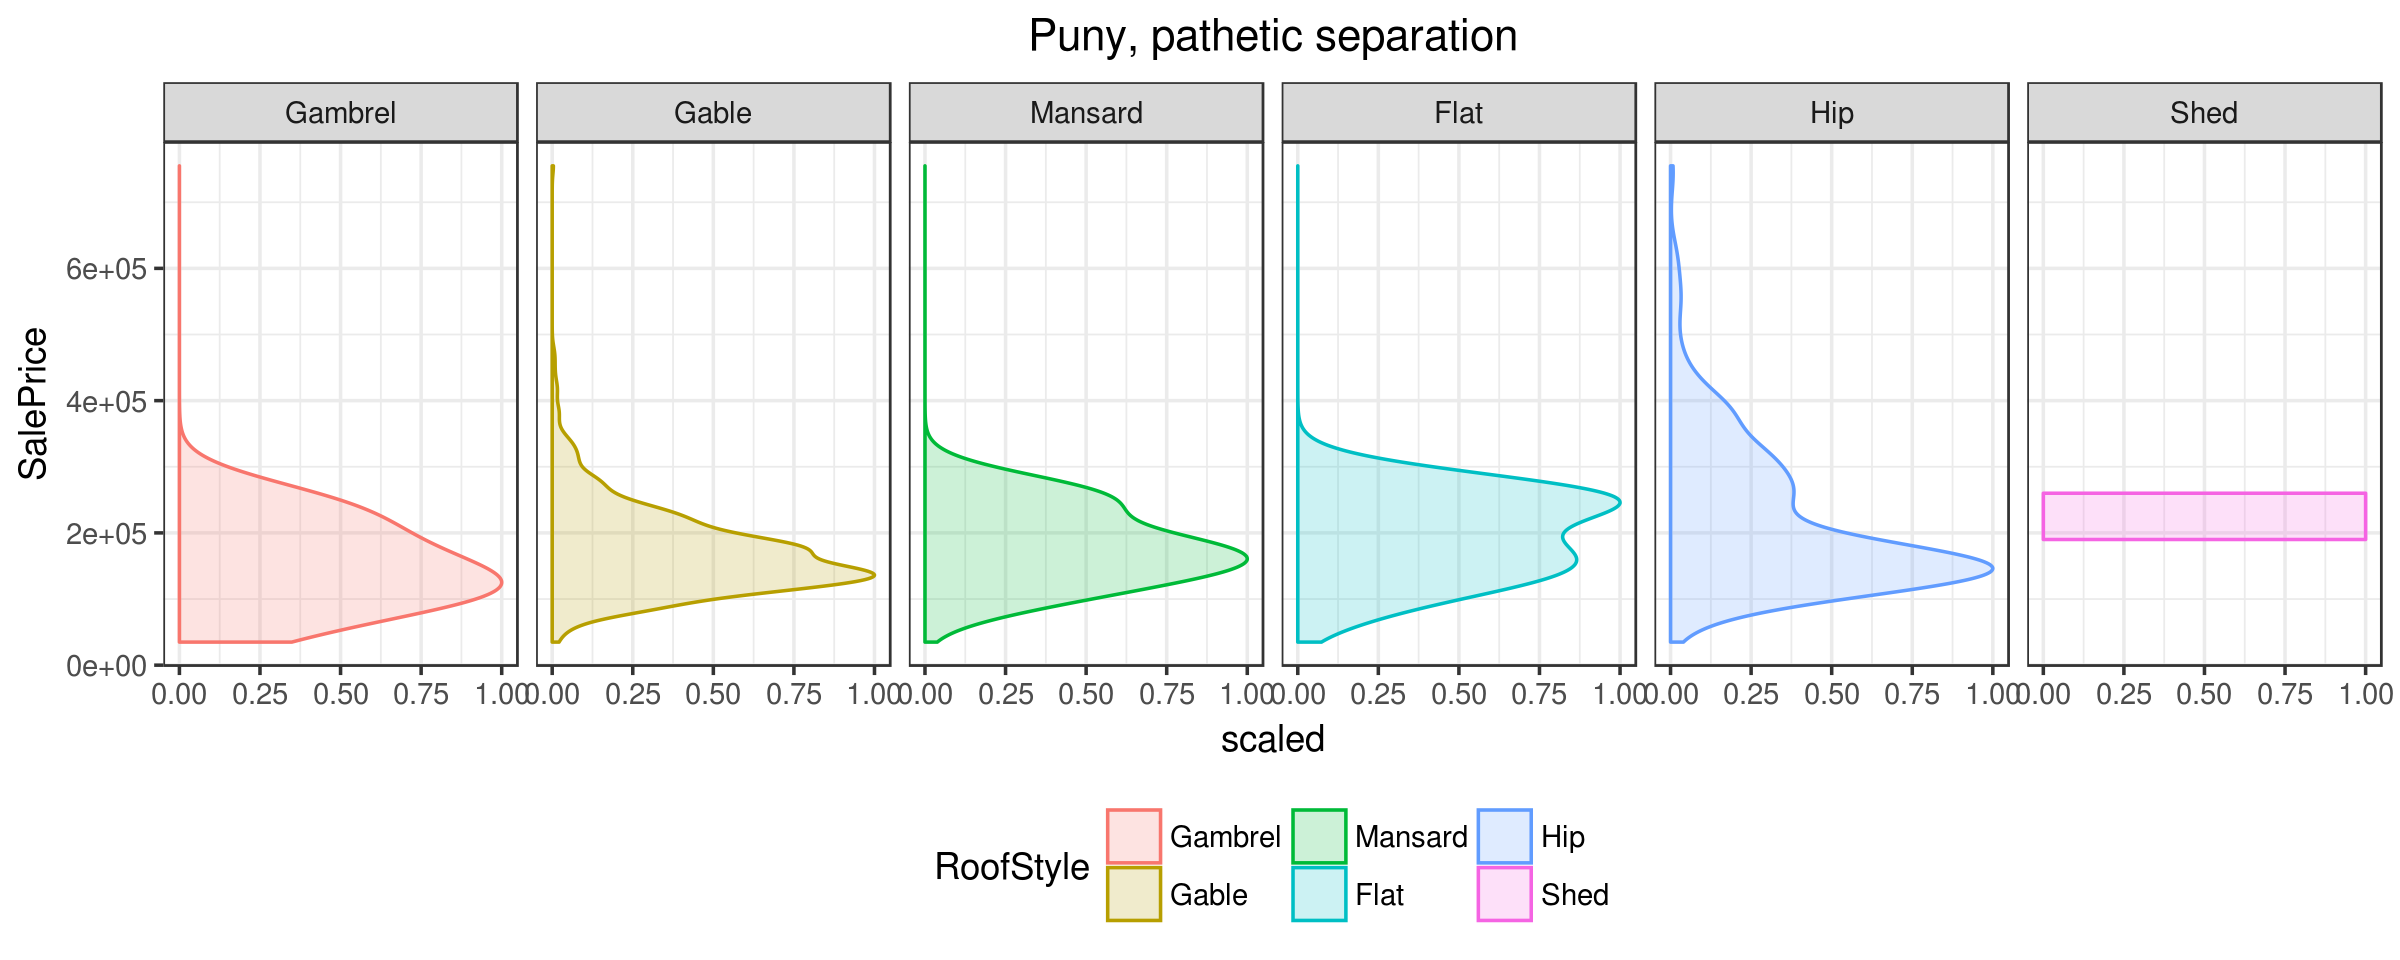

In [44]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res=240)

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
) %>%
ggplot(aes(SalePrice, color=ExterQual)) +
geom_density(aes(y=..scaled.., fill=ExterQual), alpha=.2) +
facet_wrap(~ExterQual, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Noticeable separation")

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(RoofStyle, SalePrice), 
    factor_var = RoofStyle, 
    target_var = SalePrice
) %>%
ggplot(aes(SalePrice, color=RoofStyle)) +
geom_density(aes(y=..scaled.., fill=RoofStyle), alpha=.2) +
facet_wrap(~RoofStyle, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
labs(title = "Puny, pathetic separation")

# Ordering factors by $R^2$ of log(SalePrice) ~ factor

In [49]:
Rsquared <- house_prices$attributes_selection$Rsquared

categ_vars_by_r2 <- 
    Rsquared$arrange_vars(
        df = categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice), 
        target_var = price_log
    )
numeric_vars_by_r2 <- 
    Rsquared$arrange_vars(
        df = numeric_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice), 
        target_var = price_log
    )

bind_cols(categ_vars_by_r2 %>% head(8), categ_vars_by_r2 %>% tail(8))
bind_cols(numeric_vars_by_r2 %>% head(8), numeric_vars_by_r2 %>% tail(8))

var,r2,var1,r21
Utilities,0.0001595693,Foundation,0.3036511
LandSlope,0.0014844628,GarageFinish,0.3234522
Street,0.0032912275,MSSubClass,0.3301271
BsmtFinType2,0.0070511837,BsmtQual,0.4353770
MoSold,0.0074925710,KitchenQual,0.4476397
Condition2,0.0120393620,PoolQC,0.4602011
RoofMatl,0.0179000011,ExterQual,0.4611220
LotConfig,0.0233390161,Neighborhood,0.5708078


var,r2,var1,r21
BsmtFinSF2,2.335219e-05,YearBuilt,0.3440646
BsmtHalfBath,2.651317e-05,FullBath,0.3537520
MiscVal,4.008332e-04,X1stFlrSF,0.3563864
OverallCond,1.359249e-03,TotalBsmtSF,0.3747080
YrSold,1.388529e-03,GarageArea,0.4236546
LowQualFinSF,1.441174e-03,GarageCars,0.4632501
X3SsnPorch,3.014035e-03,GrLivArea,0.4912982
PoolArea,4.871734e-03,OverallQual,0.6677904


# By Fisher statistics

### Basically one-way ANOVA

For datailed comparison with Python see `learn/anova_separation` notebook.

In [52]:
anova <- house_prices$attributes_selection$anova

df <- categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

Q_table <- anova$Q_table(df, price_log)
Q_table %>% head

# control
# should be close to zero
max((Q_table$Q_total - (Q_table$Q_within_groups + Q_table$Q_of_groups)))

categ_vars_by_fisher <- anova$arrange_vars(df, price_log)

bind_cols(categ_vars_by_fisher %>% head, categ_vars_by_fisher %>% tail)

var,num_levels,num_observ,Q_within_groups,Q_of_groups,Q_total
Alley,3,1460,226.3667,6.433964,232.8007
BldgType,5,1460,223.4560,9.344708,232.8007
BsmtCond,5,1460,212.6312,20.169471,232.8007
BsmtExposure,5,1460,199.6048,33.195897,232.8007
BsmtFinType1,7,1460,179.8018,52.998896,232.8007
BsmtFinType2,7,1460,222.7261,10.074509,232.8007


[1] 3.410605e-13

var,F,var1,F1
Utilities,0.2326891,FireplaceQu,131.1985
MoSold,0.9937405,CentralAir,205.6670
LandSlope,1.0830389,GarageFinish,298.7698
Condition2,2.5277400,BsmtQual,300.3923
MiscFeature,3.6212358,KitchenQual,393.3202
RoofMatl,3.7806452,ExterQual,415.3034


# Discarding weak categorical variables

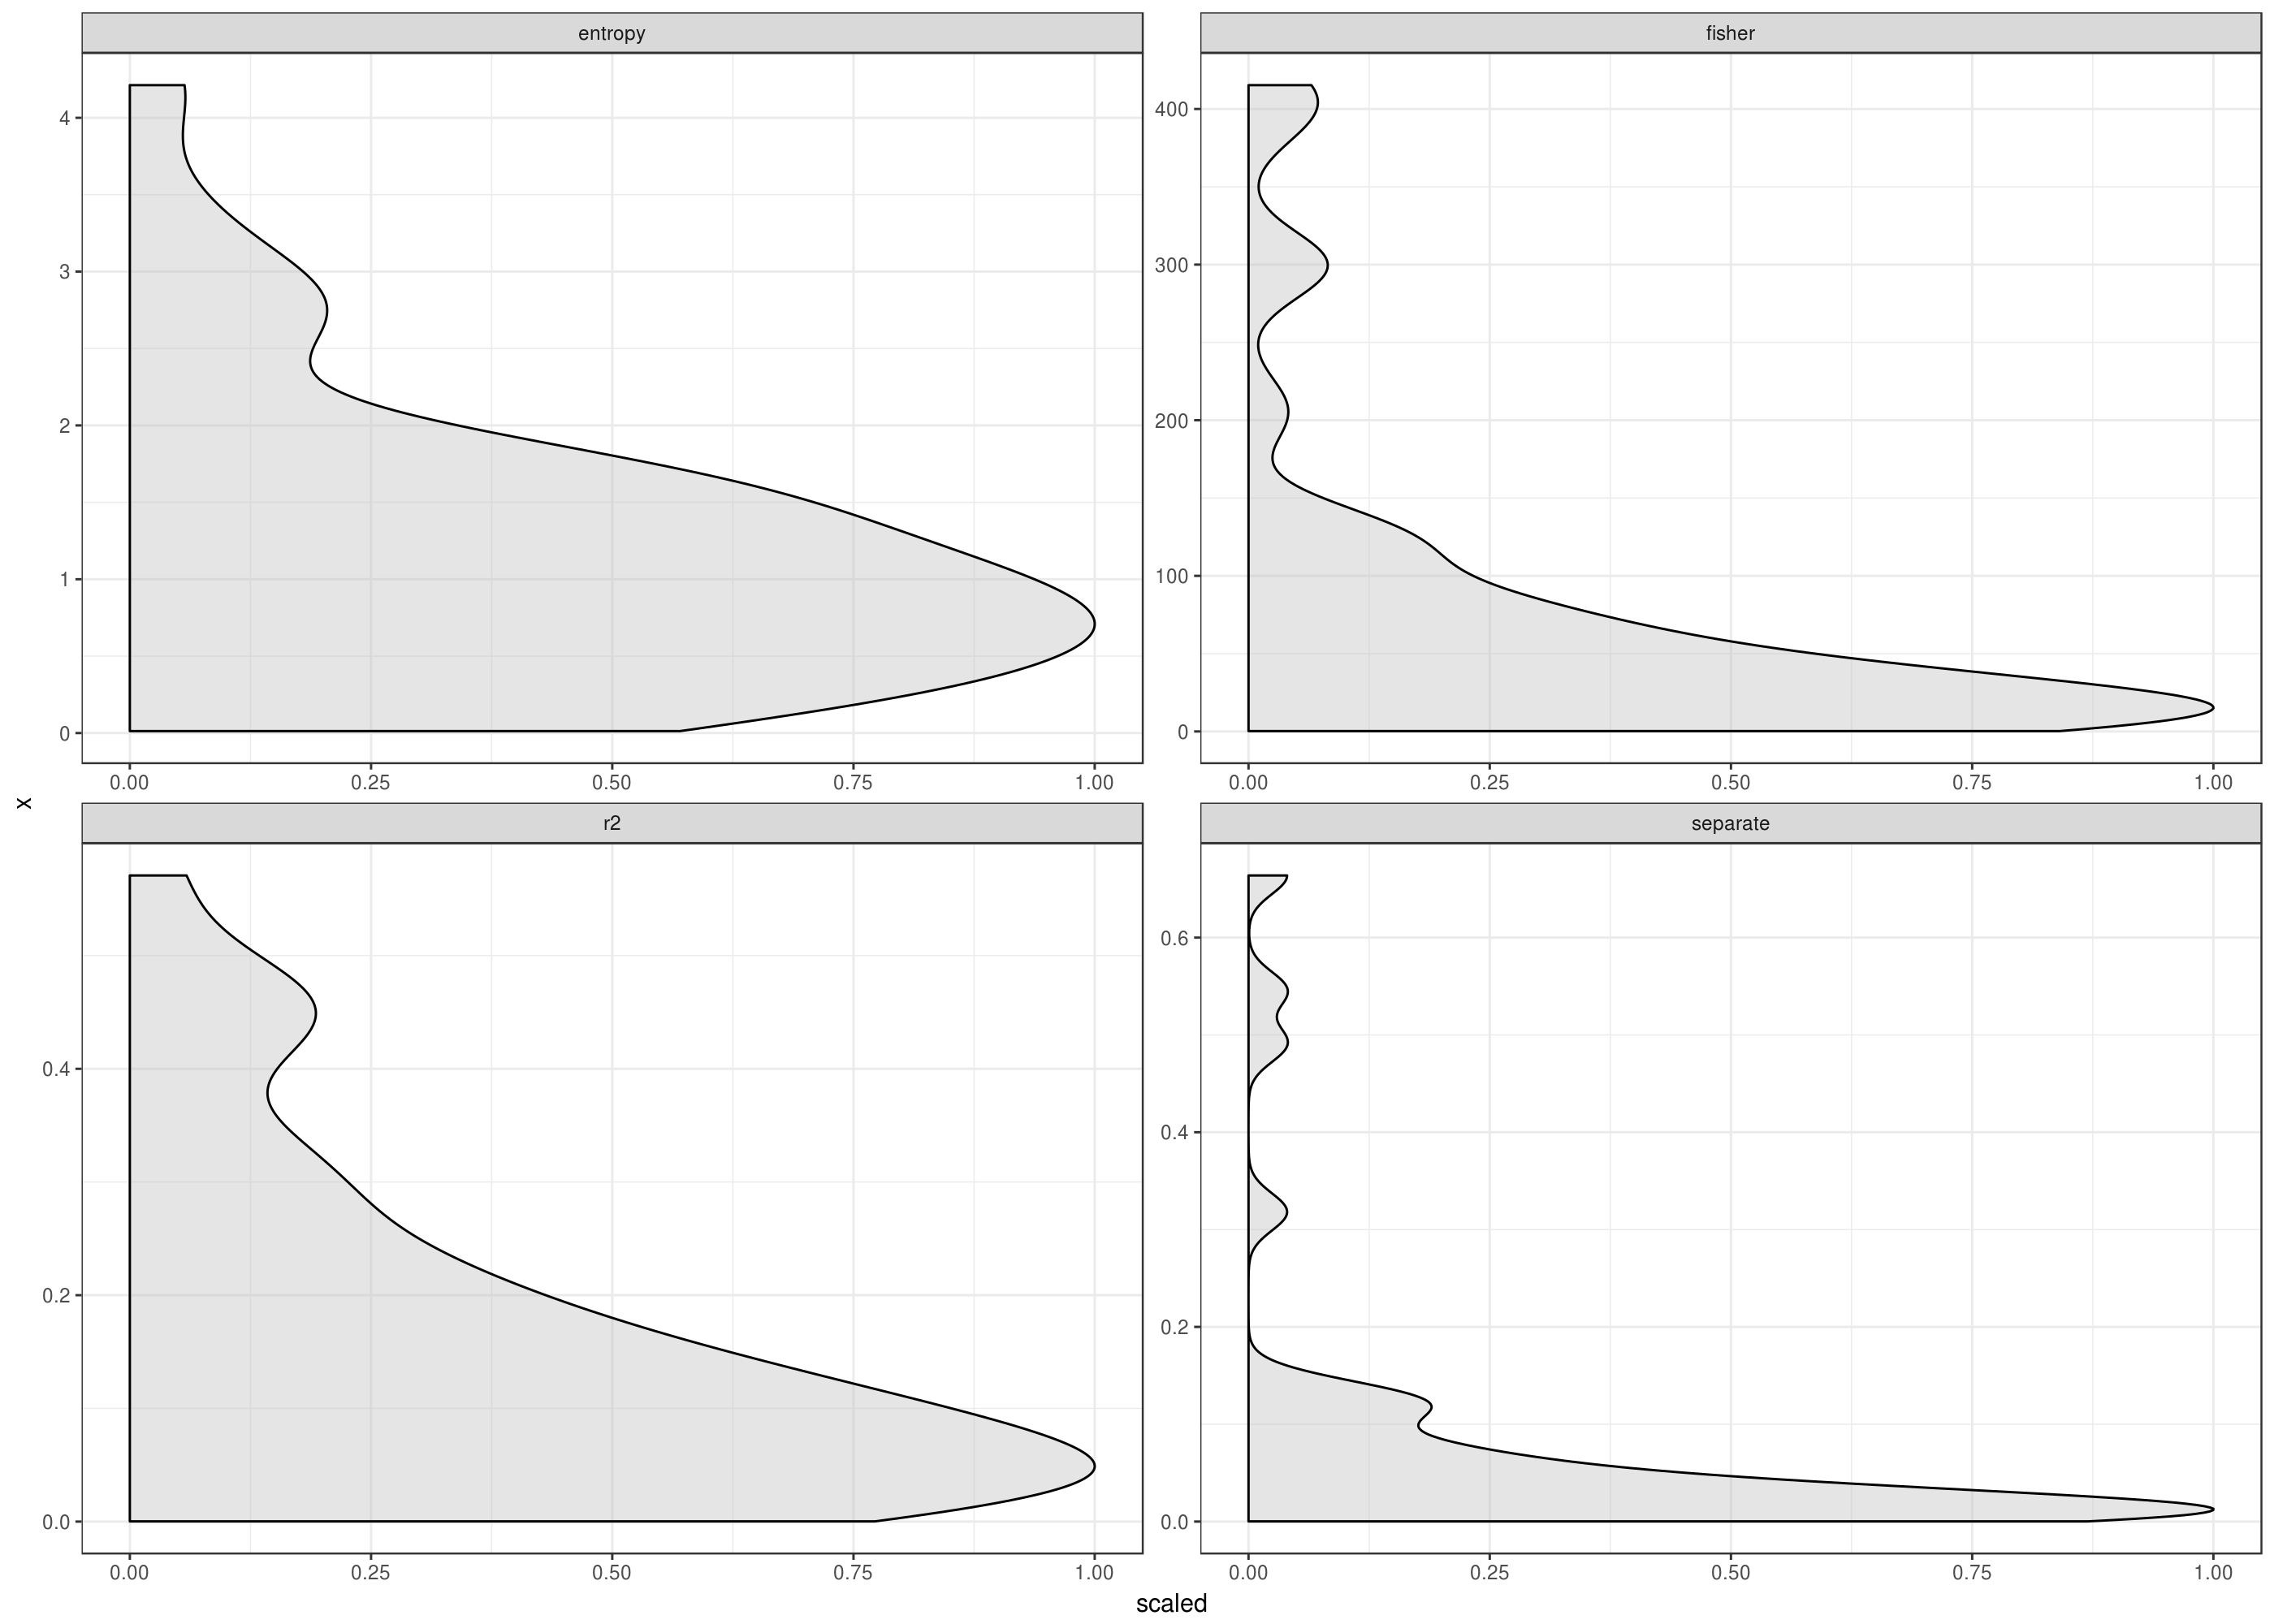

In [53]:
options(repr.plot.width = 14, repr.plot.height = 10, repr.plot.res=200)

entropy <- house_prices$attributes_selection$entropy
groups_separation <- house_prices$attributes_selection$groups_separation
Rsquared <- house_prices$attributes_selection$Rsquared
anova <- house_prices$attributes_selection$anova

df <- categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

cat_by_entropy <- entropy$arrange_vars(df %>% select(-price_log))
cat_by_groups_separation <- groups_separation$arrange_vars(df, price_log)
cat_by_r2 <- Rsquared$arrange_vars(df, price_log)
cat_by_fisher <- anova$arrange_vars(df, price_log)

bind_rows(
    cat_by_entropy %>% mutate(method = 'entropy') %>% rename(x=entropy),
    cat_by_groups_separation %>% mutate(method = 'separate') %>% rename(x=score),
    cat_by_r2 %>% mutate(method = 'r2') %>% rename(x=r2),
    cat_by_fisher %>% mutate(method = 'fisher') %>% rename(x=F)
) %>% 
ggplot(aes(x)) +
geom_density(aes(y=..scaled..), alpha=0.4, fill='grey') +
facet_wrap(~method, nrow=2, ncol=2, scales = "free") +
coord_flip() +
theme_bw()

In [55]:
x1 <- cat_by_entropy %>% filter(entropy < 1) %>% `[[`('var')
x2 <- cat_by_groups_separation %>% filter(score < 0.2) %>% `[[`('var')
x3 <- cat_by_r2 %>% filter(r2 < 0.1) %>% `[[`('var')
x4 <- cat_by_fisher %>% filter(F < 100) %>% `[[`('var')

cat_virgin_vars <- Reduce(intersect, list(x1, x2, x3, x4)) %>% sort
cat_chad_vars <- setdiff(categ_data %>% colnames, cat_virgin_vars) %>% sort

# weak attributes
cat_virgin_vars %>% print
# strong attributes
cat_chad_vars %>% print

 [1] "BldgType"     "BsmtCond"     "BsmtFinType2" "Condition1"   "Condition2"  
 [6] "Electrical"   "ExterCond"    "Functional"   "GarageCond"   "GarageQual"  
[11] "Heating"      "LandContour"  "LandSlope"    "PavedDrive"   "RoofMatl"    
[16] "RoofStyle"    "Street"       "Utilities"   
 [1] "Alley"         "BsmtExposure"  "BsmtFinType1"  "BsmtQual"     
 [5] "CentralAir"    "Exterior1st"   "Exterior2nd"   "ExterQual"    
 [9] "Fence"         "FireplaceQu"   "Foundation"    "GarageFinish" 
[13] "GarageType"    "HeatingQC"     "HouseStyle"    "KitchenQual"  
[17] "LotConfig"     "LotShape"      "MasVnrType"    "MiscFeature"  
[21] "MoSold"        "MSSubClass"    "MSZoning"      "Neighborhood" 
[25] "PoolQC"        "SaleCondition" "SalePrice"     "SaleType"     


## Eyeballing weak categorical attributes

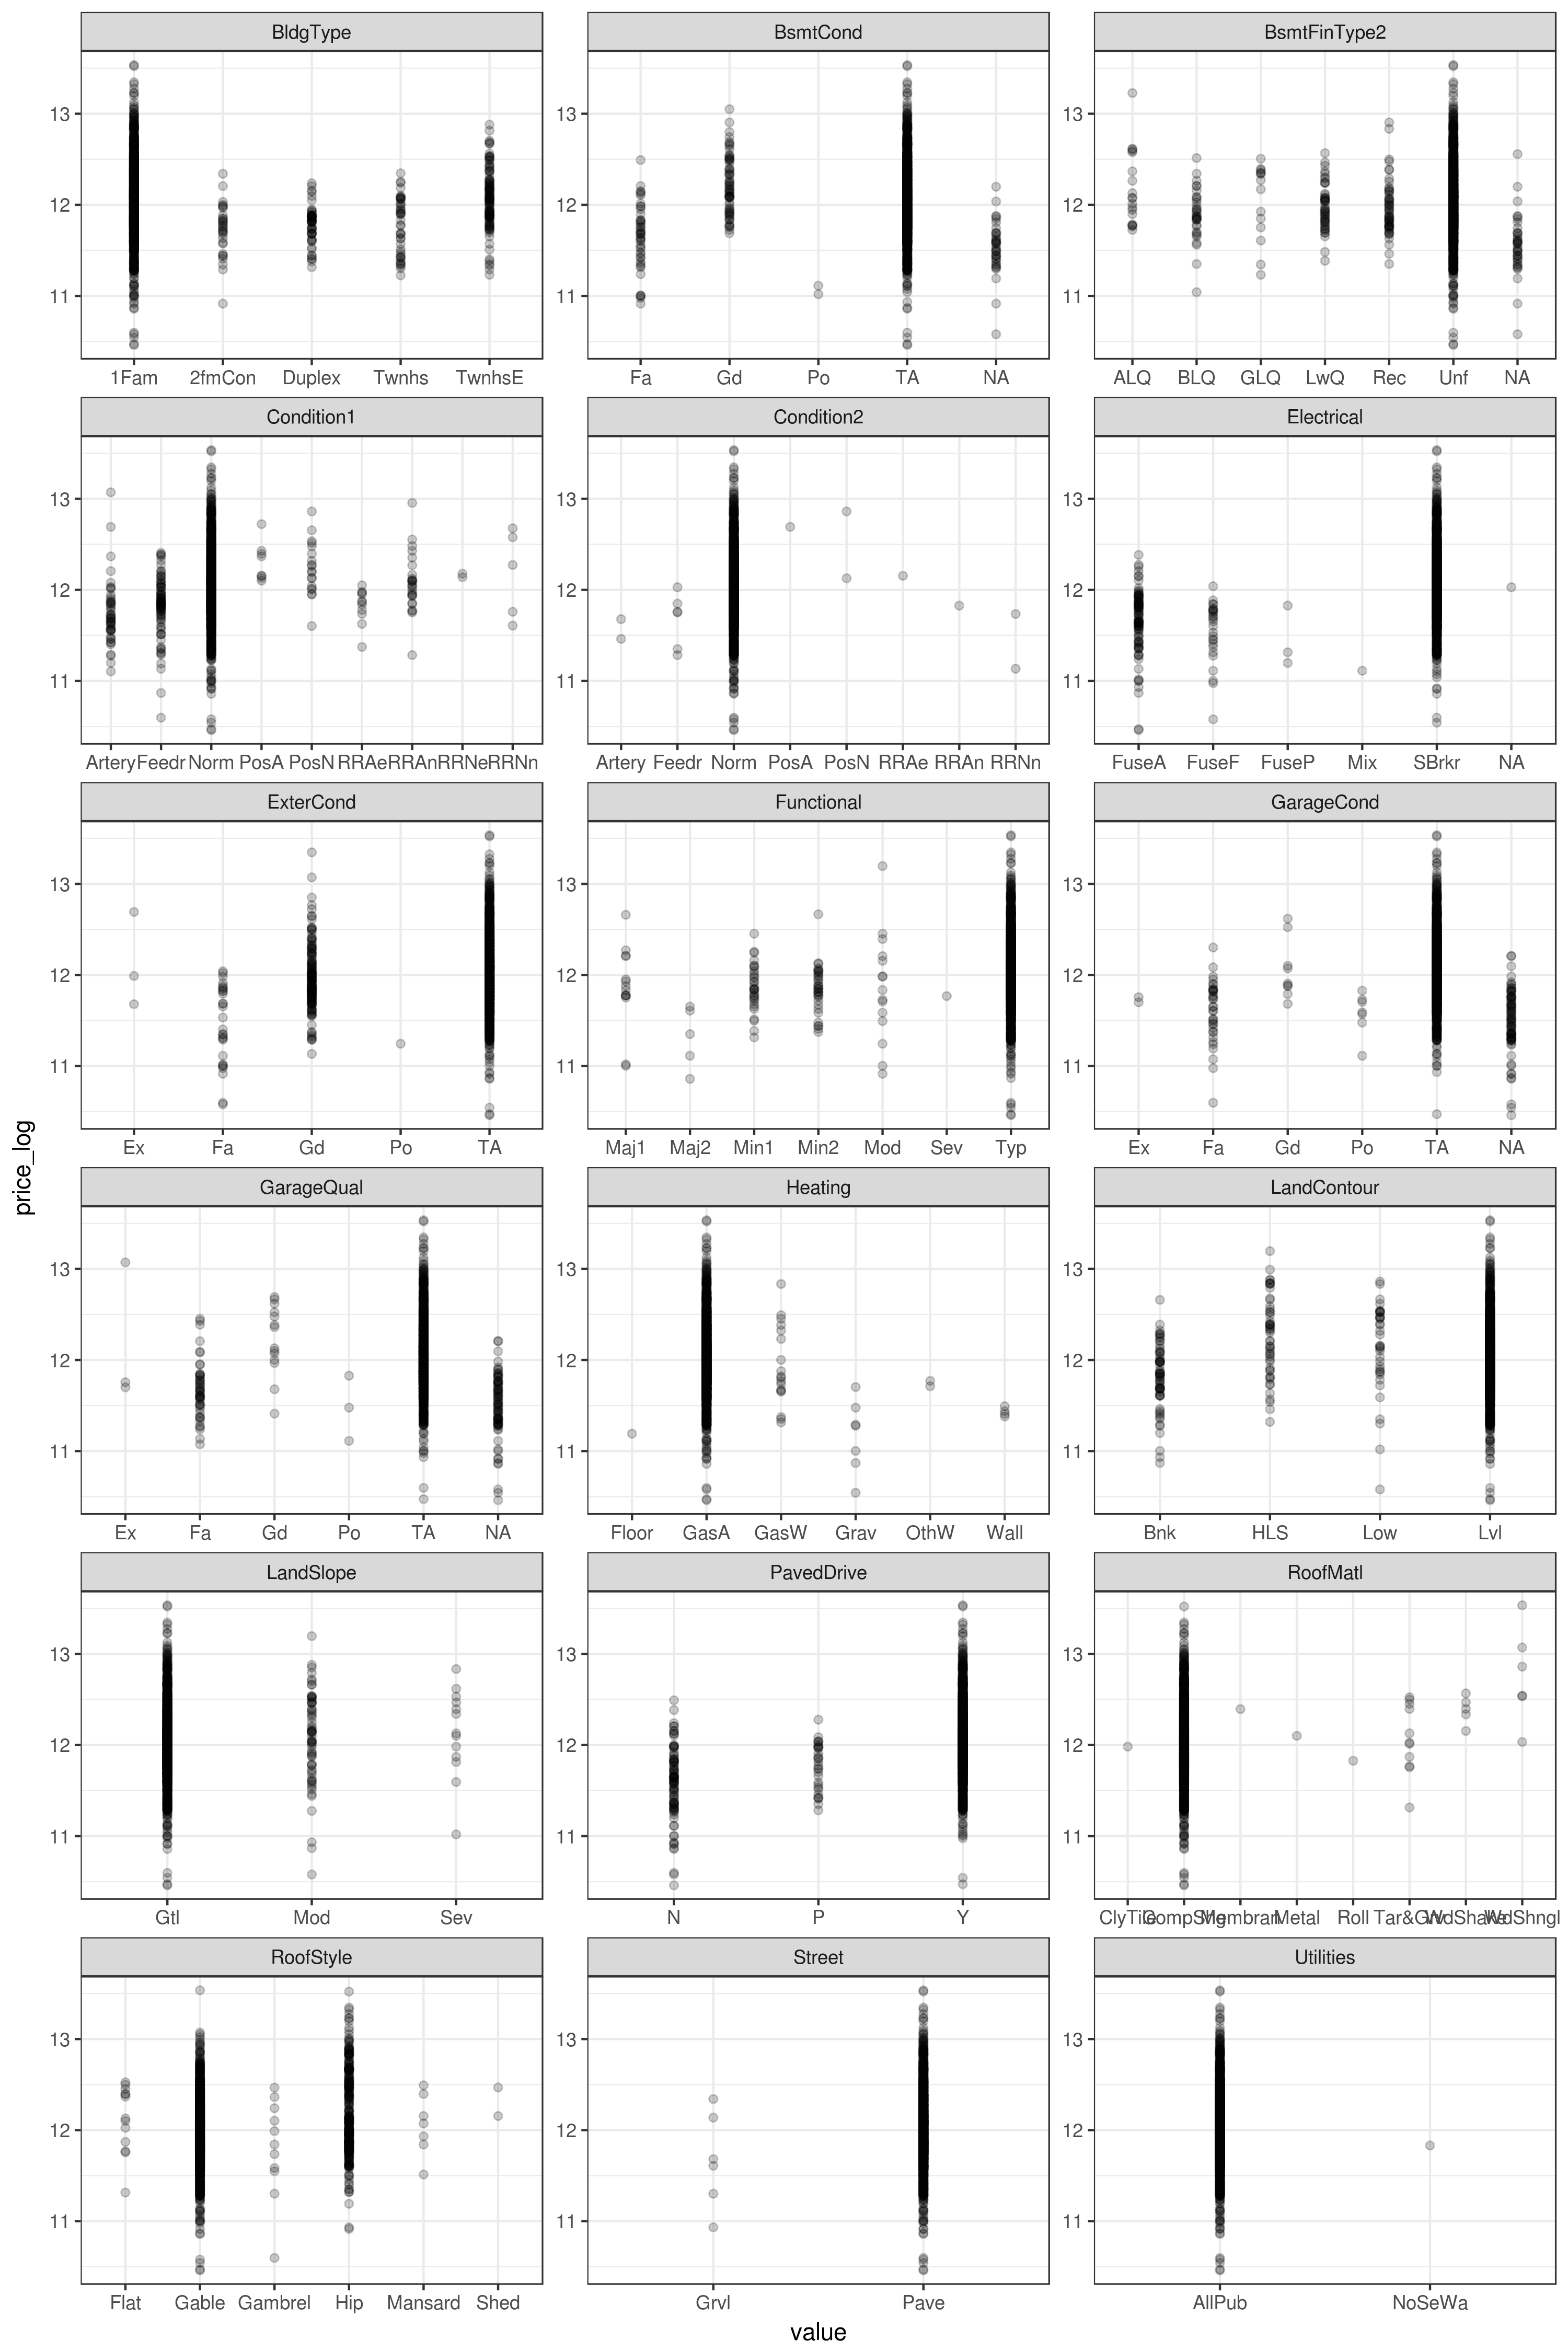

In [56]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res=300)

categ_data %>%
mutate(price_log = log(SalePrice)) %>%
select(one_of(cat_virgin_vars), price_log) %>%
filter(!is.na(price_log)) %>%
gather(var, value, -price_log) %>%
ggplot(aes(x = value, y = price_log)) +
geom_point(alpha = 0.2) +
facet_wrap(~var, ncol=3, scale="free") +
theme_bw()

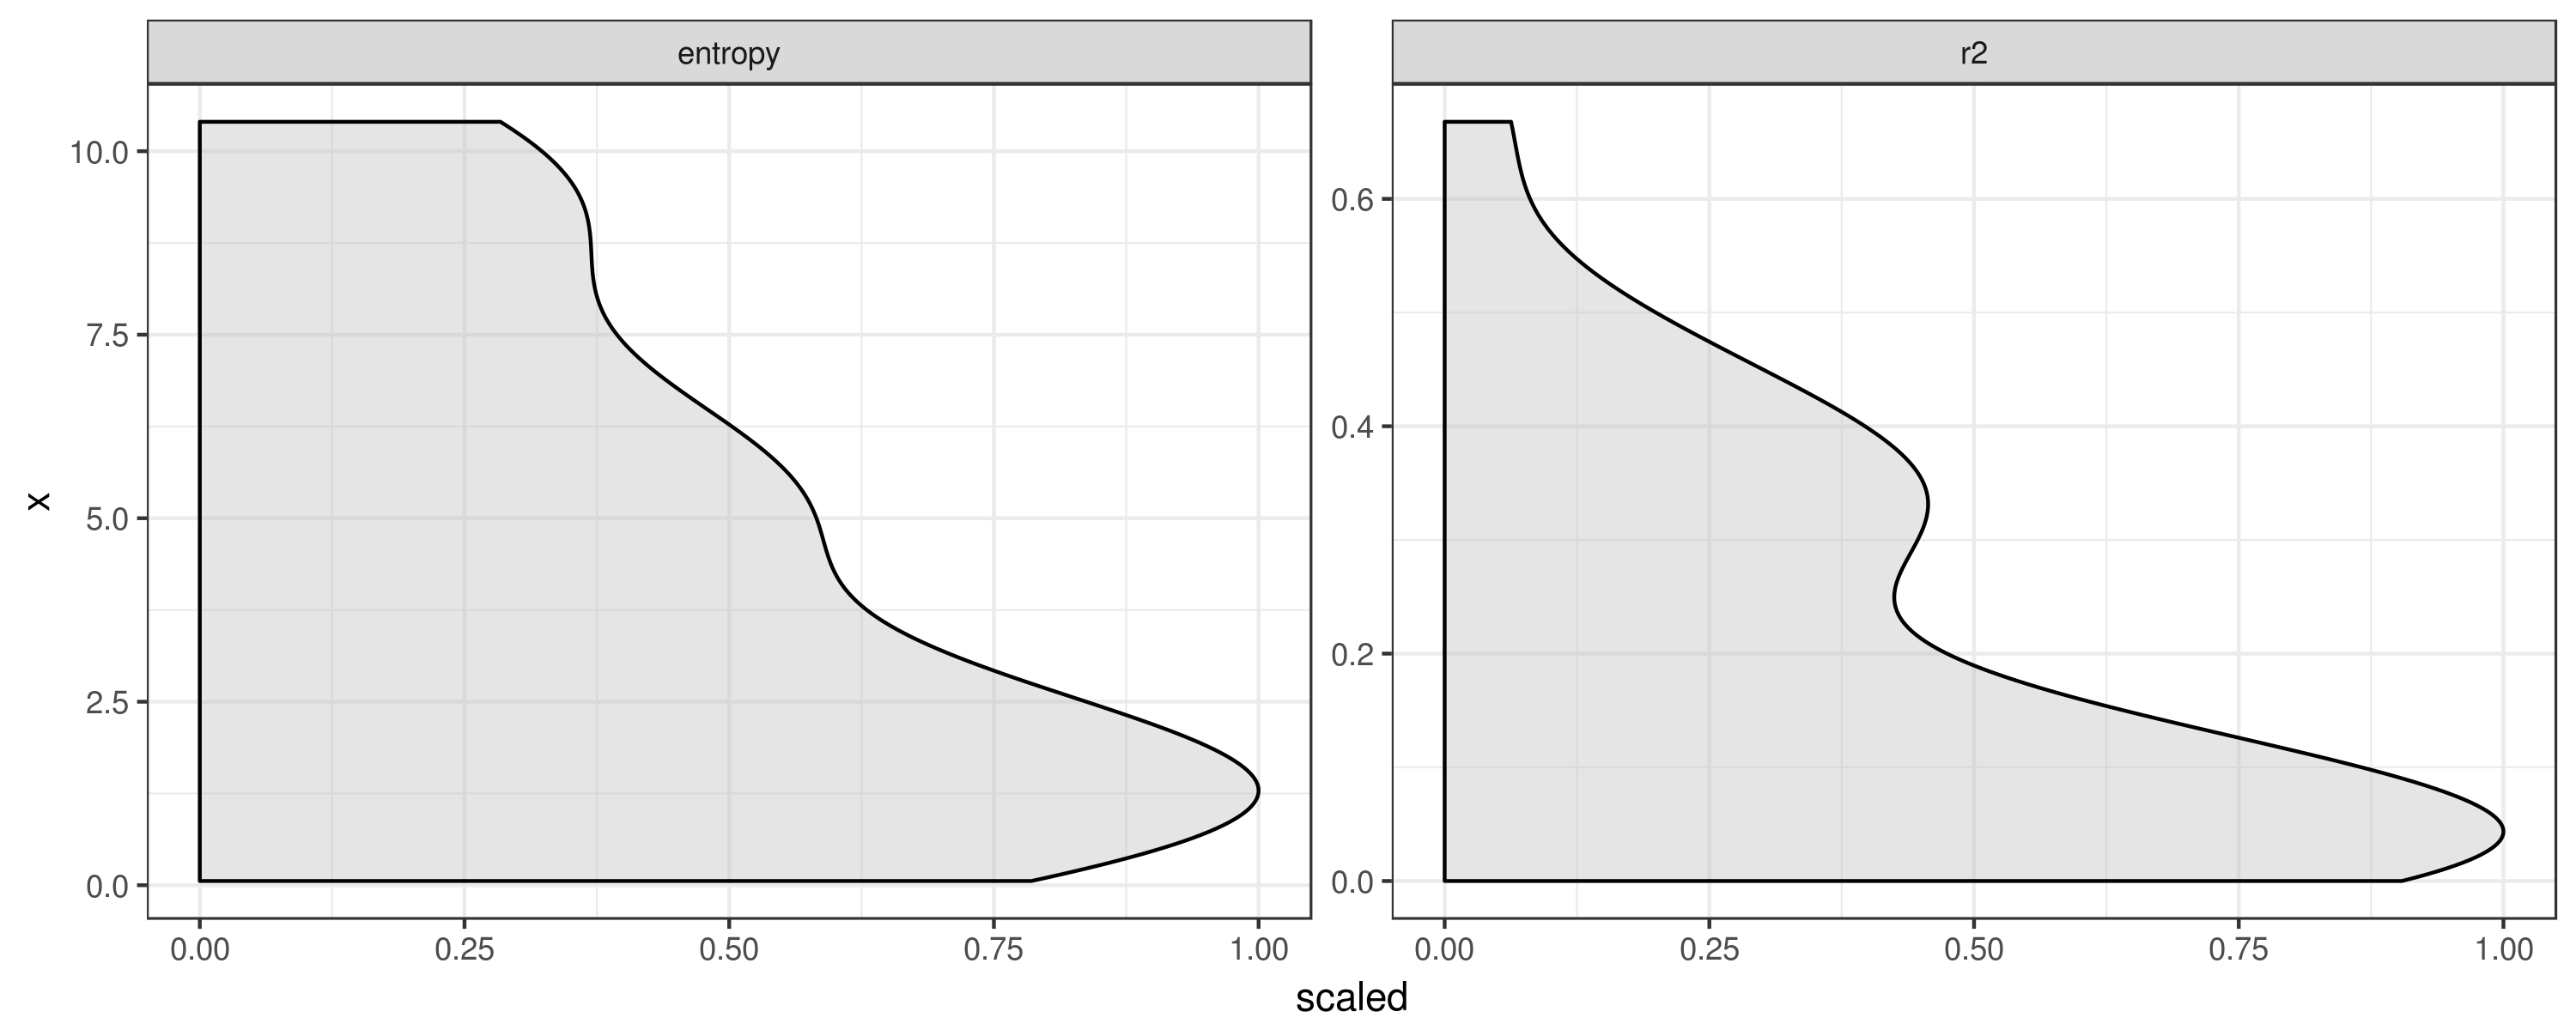

In [57]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res=300)

df <- numeric_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

num_by_entropy <- entropy$arrange_vars(df)
num_by_r2 <- Rsquared$arrange_vars(df, price_log)

bind_rows(
    num_by_entropy %>% mutate(method = 'entropy') %>% rename(x=entropy),
    num_by_r2 %>% mutate(method = 'r2') %>% rename(x=r2)
) %>%
ggplot(aes(x)) +
geom_density(aes(y=..scaled..), alpha=0.4, fill='grey') +
facet_wrap(~method, nrow=1, ncol=2, scales = "free") +
coord_flip() +
theme_bw()

In [58]:
x1 <- num_by_entropy %>% filter(entropy < 2) %>% `[[`('var')
x2 <- num_by_r2 %>% filter(r2 < 0.1) %>% `[[`('var')

num_virgin_vars <- Reduce(intersect, list(x1, x2)) %>% sort
num_chad_vars <- setdiff(numeric_data %>% colnames, num_virgin_vars) %>% sort

# weak attributes
num_virgin_vars %>% print
# strong attributes
num_chad_vars %>% print

 [1] "BedroomAbvGr"  "BsmtFinSF2"    "BsmtFullBath"  "BsmtHalfBath" 
 [5] "EnclosedPorch" "HalfBath"      "KitchenAbvGr"  "LowQualFinSF" 
 [9] "MiscVal"       "OverallCond"   "PoolArea"      "ScreenPorch"  
[13] "X3SsnPorch"   
 [1] "BsmtFinSF1"   "BsmtUnfSF"    "Fireplaces"   "FullBath"     "GarageArea"  
 [6] "GarageCars"   "GarageYrBlt"  "GrLivArea"    "LotArea"      "LotFrontage" 
[11] "MasVnrArea"   "OpenPorchSF"  "OverallQual"  "SalePrice"    "TotalBsmtSF" 
[16] "TotRmsAbvGrd" "WoodDeckSF"   "X1stFlrSF"    "X2ndFlrSF"    "YearBuilt"   
[21] "YearRemodAdd" "YrSold"      


### Eyeballing weak numeric attributes

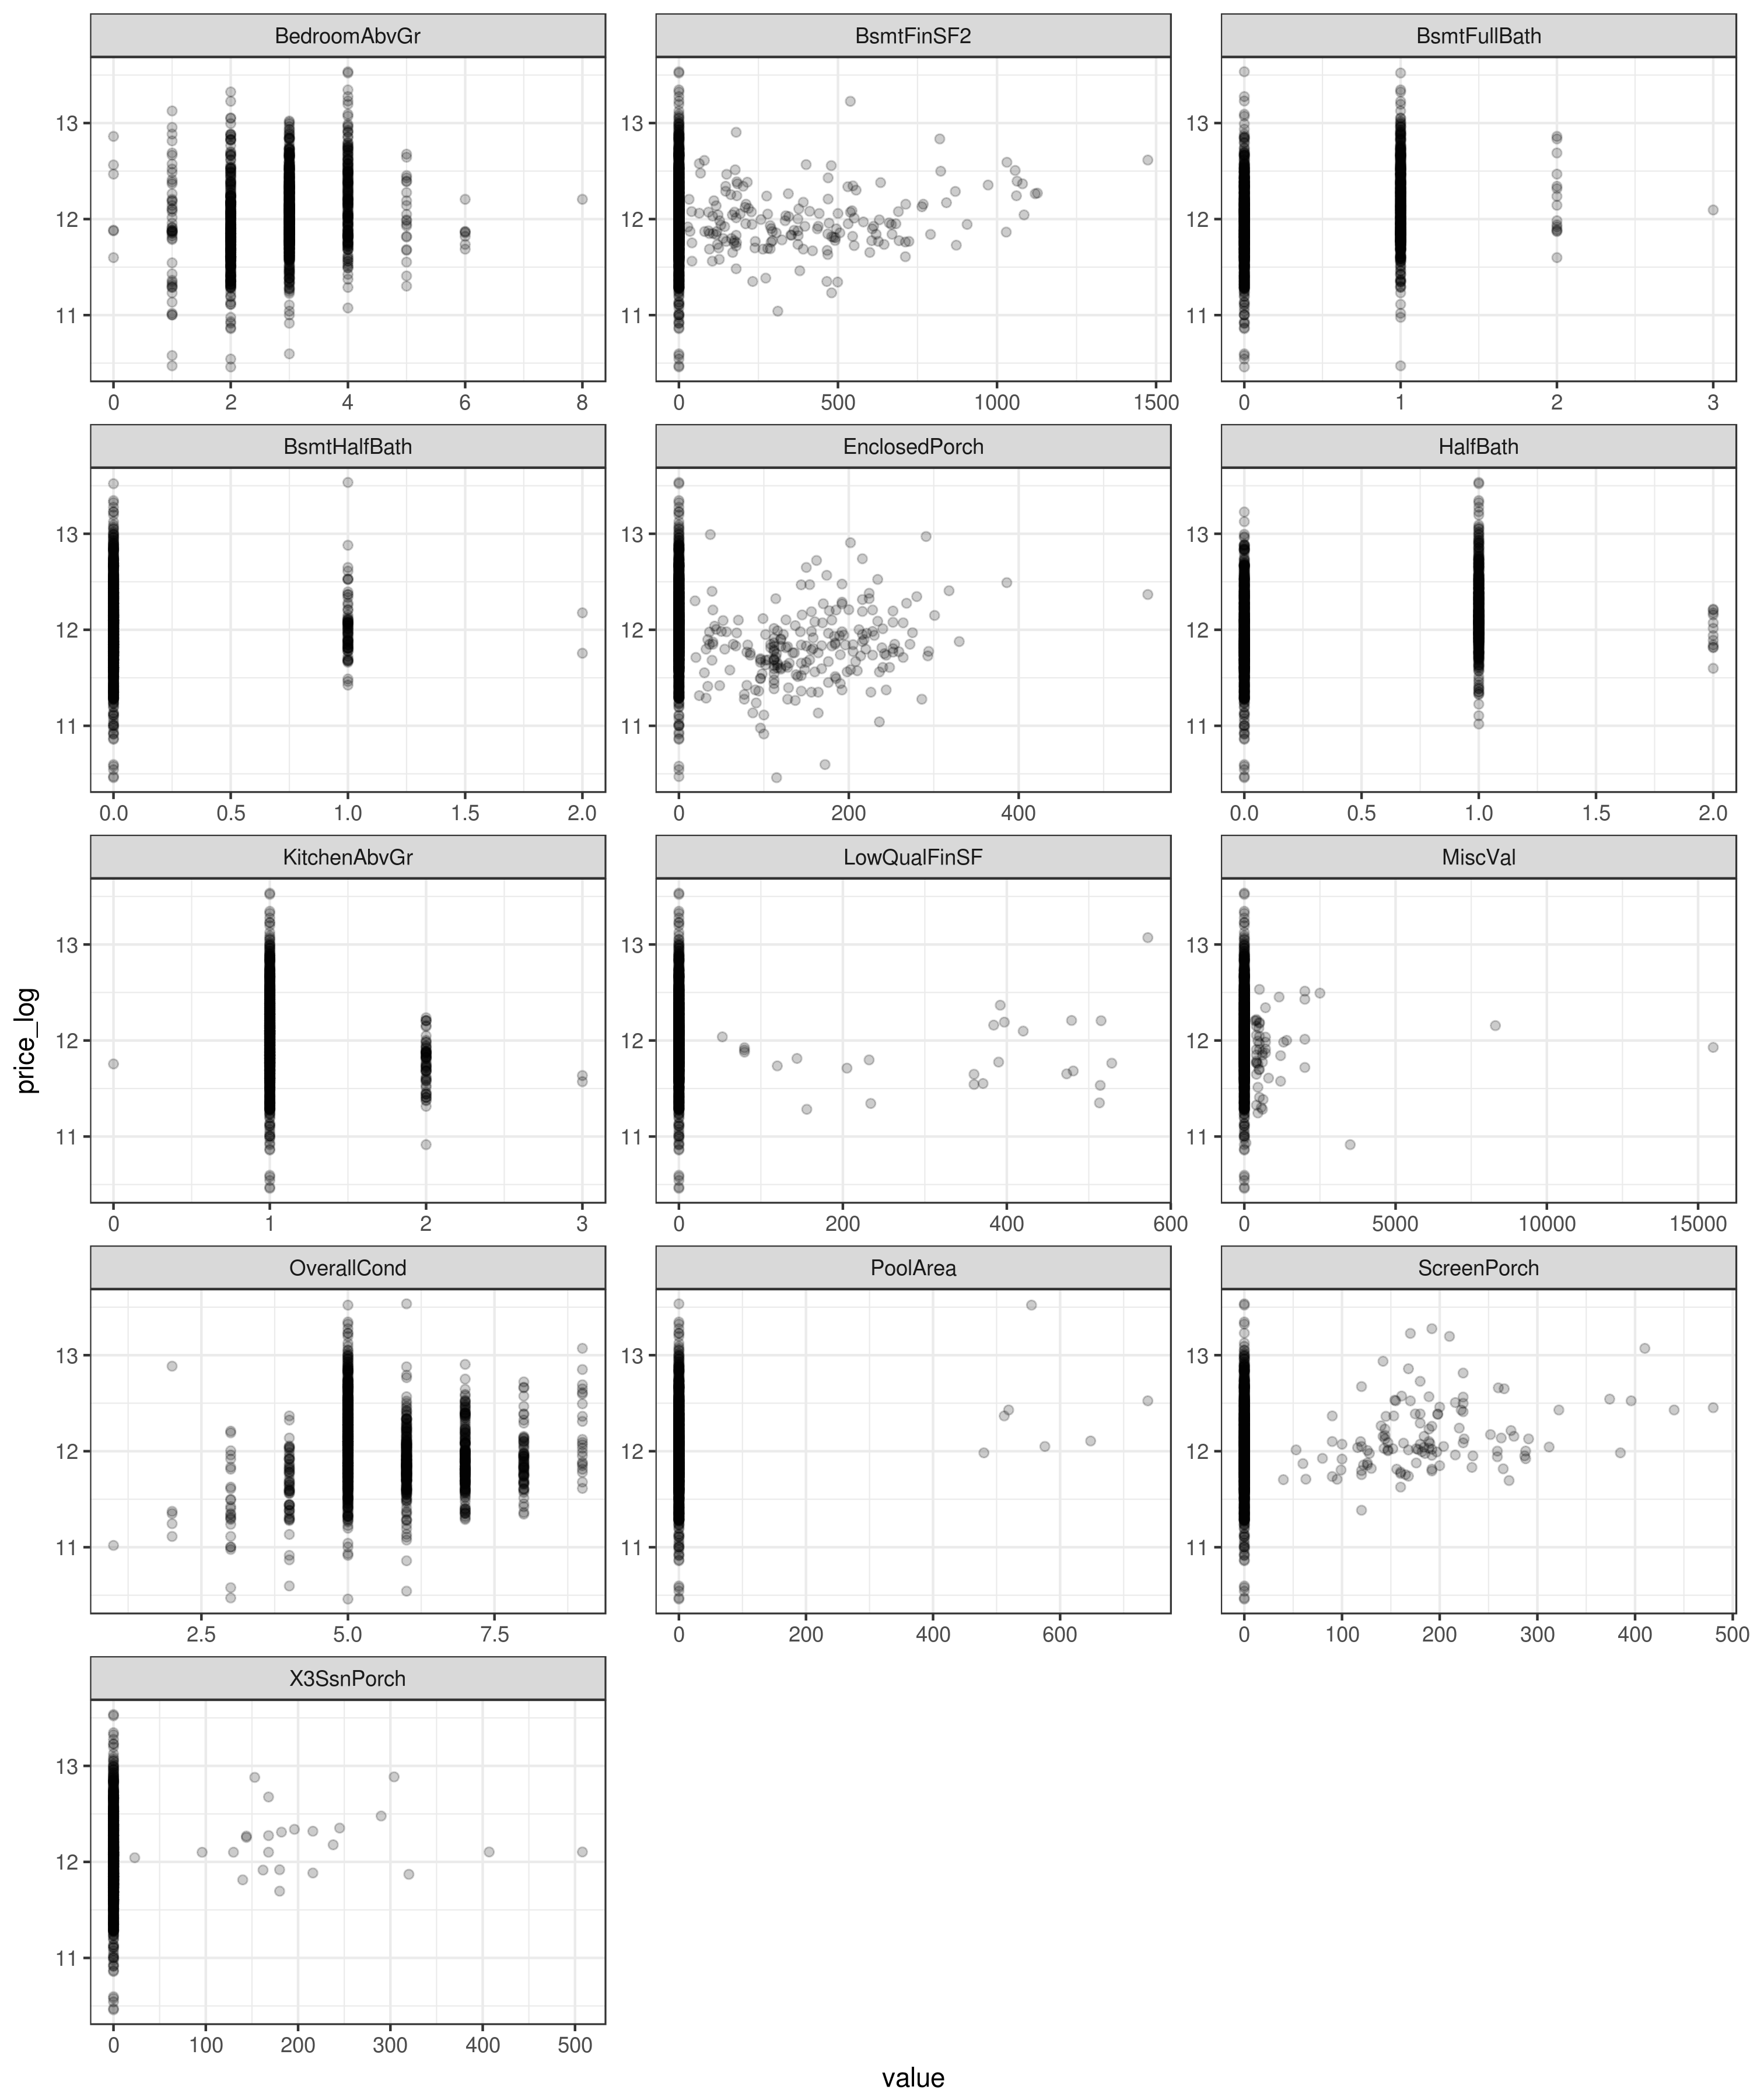

In [59]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res=300)

numeric_data %>%
mutate(price_log = log(SalePrice)) %>%
select(one_of(num_virgin_vars), price_log) %>%
filter(!is.na(price_log)) %>%
gather(var, value, -price_log) %>%
ggplot(aes(x = value, y = price_log)) +
geom_point(alpha = 0.2) +
facet_wrap(~var, ncol=3, scale="free") +
theme_bw()